In [1]:
from keras.applications.xception import Xception
conv_base = Xception(weights='imagenet',include_top=False,input_shape=(224,224,3),pooling='avg')
conv_base.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
base_dir = '/home/ankur248/PycharmProjects/Testing1/BMI_Project/Face_to_BMI_Dataset/FTBSplit'
train_dir = os.path.join(base_dir,'Train')
validation_dir = os.path.join(base_dir,'Validation')
test_dir = os.path.join(base_dir,'Test')

In [3]:
import pandas as pd
df = pd.read_csv(r"/home/ankur248/PycharmProjects/Testing1/BMI_Project/Face_to_BMI_Dataset/Data/data.csv")
print("Dataset_Shape="+str(df.shape))
print(df.head())
labels_batch=np.array(df['bmi'])

Dataset_Shape=(4206, 5)
   Unnamed: 0        bmi  gender  is_training       name
0           0  34.207396    Male            1  img_0.bmp
1           1  26.453720    Male            1  img_1.bmp
2           2  34.967561  Female            1  img_2.bmp
3           3  22.044766  Female            1  img_3.bmp
4           4  37.758789  Female            1  img_4.bmp


In [4]:
train_labels=df.iloc[0:3368]
x=[]
for im in os.listdir(os.path.join(train_dir,'Train')):
    x.append(train_labels[train_labels['name']==im].values[0])
train_labels=pd.DataFrame(x)
train_labels.rename(columns={1:'bmi'},inplace=True)
train_labels=train_labels[[0,'bmi']]
train_labels.set_index(0,inplace=True)

In [5]:
from keras.preprocessing import image 
train_images=[]
for im in os.listdir(os.path.join(train_dir,'Train')):
    img=image.load_img(os.path.join(train_dir,'Train/'+im),target_size=(224,224))
    img=image.img_to_array(img)
    train_images.append(img)
train_images=np.array(train_images)

In [6]:
Validation_labels=df.iloc[3368:4206]
y=[]
for im in os.listdir(os.path.join(validation_dir,'Validation')):
    y.append(Validation_labels[Validation_labels['name']==im].values[0])
Validation_labels=pd.DataFrame(y)
Validation_labels.rename(columns={1:'bmi'},inplace=True)
Validation_labels=Validation_labels[[0,'bmi']]
Validation_labels.set_index(0,inplace=True)

In [7]:
Validation_images=[]
for im in os.listdir(os.path.join(validation_dir,'Validation')):
    img=image.load_img(os.path.join(validation_dir,'Validation/'+im),target_size=(224,224))
    img=image.img_to_array(img)
    Validation_images.append(img)
Validation_images=np.array(Validation_images)

In [8]:
from keras import models
from keras import layers
from keras import optimizers
import keras.backend as K
import tensorflow as tf
from keras import regularizers

def l1_smooth_loss(y_true, y_pred):
    x = K.abs(y_true - y_pred)
    x = tf.where(tf.less(x, 1.0), 0.5 * x ** 2, x - 0.5)
    return K.sum(x)


In [9]:
from keras import callbacks
callbacks_list = [callbacks.ModelCheckpoint(filepath='Xception.h5',monitor='val_loss',save_best_only=True,)]

model = models.Sequential()
model.add(conv_base)
for layer in conv_base.layers:
    layer.trainable = False

model.add(layers.Dense(256,activation='relu',input_dim=2048,kernel_regularizer=regularizers.l2(0.01)))

model.add(layers.Dropout(0.2))
model.add(layers.Dense(1,activation=None))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss=l1_smooth_loss,
             metrics=['mae'])
history= model.fit(train_images,train_labels,
                  epochs=30,
                  batch_size=20,
                  callbacks=callbacks_list,
                  validation_data=(Validation_images,Validation_labels))

Train on 3368 samples, validate on 838 samples
Epoch 1/30
3368/3368 [==============================] - 42s 12ms/step - loss: 552.0758 - mean_absolute_error: 27.9115 - val_loss: 491.6874 - val_mean_absolute_error: 24.9001
Epoch 2/30
3368/3368 [==============================] - 30s 9ms/step - loss: 382.0312 - mean_absolute_error: 19.3990 - val_loss: 330.1083 - val_mean_absolute_error: 16.8092
Epoch 3/30
3368/3368 [==============================] - 30s 9ms/step - loss: 256.2107 - mean_absolute_error: 13.1026 - val_loss: 246.1682 - val_mean_absolute_error: 12.6079
Epoch 4/30
3368/3368 [==============================] - 31s 9ms/step - loss: 216.8130 - mean_absolute_error: 11.1305 - val_loss: 225.4701 - val_mean_absolute_error: 11.5836
Epoch 5/30
3368/3368 [==============================] - 31s 9ms/step - loss: 211.7149 - mean_absolute_error: 10.8942 - val_loss: 219.6041 - val_mean_absolute_error: 11.3008
Epoch 6/30
3368/3368 [==============================] - 30s 9ms/step - loss: 209.4672 -

In [ ]:
import matplotlib.pyplot as plt
def my_plot(h):  
    mae = h['mean_absolute_error']
    val_mae = h['val_mean_absolute_error']
    loss = h['loss']
    val_loss = h['val_loss']
    epochs = range(1,len(mae)+1)

    plt.plot(epochs,mae,'r',label='Training mean_absolute_error')
    plt.plot(epochs,val_mae,'b',label='Validation mean_absolute_error')
    plt.title('Training and validation mean_absolute_error')
    plt.legend()

    plt.figure()
    plt.plot(epochs,loss,'r',label='Training loss')
    plt.plot(epochs,val_loss,'b',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()
my_plot(history.history)

In [11]:
for layer in conv_base.layers[15:]:
    layer.trainable = True
model.compile(optimizer=optimizers.SGD(lr=1e-5,decay=0.0005,momentum=0.9),
             loss=l1_smooth_loss,
             metrics=['mae'])
history= model.fit(train_images,train_labels,
                  epochs=20,
                  batch_size=16, 
                  callbacks=callbacks_list,
                  validation_data=(Validation_images,Validation_labels))

Train on 3368 samples, validate on 838 samples
Epoch 1/20
3368/3368 [==============================] - 84s 25ms/step - loss: 100.7958 - mean_absolute_error: 6.6358 - val_loss: 108.0756 - val_mean_absolute_error: 7.1154
Epoch 2/20
3368/3368 [==============================] - 79s 24ms/step - loss: 72.2492 - mean_absolute_error: 4.8456 - val_loss: 90.3906 - val_mean_absolute_error: 5.9967
Epoch 3/20
3368/3368 [==============================] - 78s 23ms/step - loss: 57.1679 - mean_absolute_error: 3.8945 - val_loss: 89.8932 - val_mean_absolute_error: 5.9581
Epoch 4/20
3368/3368 [==============================] - 78s 23ms/step - loss: 51.9811 - mean_absolute_error: 3.5688 - val_loss: 87.2725 - val_mean_absolute_error: 5.7981
Epoch 5/20
3368/3368 [==============================] - 78s 23ms/step - loss: 47.0705 - mean_absolute_error: 3.2568 - val_loss: 86.5151 - val_mean_absolute_error: 5.7500
Epoch 6/20
3368/3368 [==============================] - 77s 23ms/step - loss: 44.5510 - mean_absolute

In [20]:
for layer in conv_base.layers:
    layer.trainable = True
model.compile(optimizer=optimizers.RMSprop(lr=1e-5,decay=(1e-5/20)),
             loss=l1_smooth_loss,
             metrics=['mae'])
history= model.fit(train_images,train_labels,
                  epochs=20,
                  batch_size=16, 
                  callbacks=callbacks_list,
                  validation_data=(Validation_images,Validation_labels))

Train on 3368 samples, validate on 838 samples
Epoch 1/20
3368/3368 [==============================] - 114s 34ms/step - loss: 28.2864 - mean_absolute_error: 2.0732 - val_loss: 82.2107 - val_mean_absolute_error: 5.4783
Epoch 2/20
3368/3368 [==============================] - 110s 33ms/step - loss: 27.1126 - mean_absolute_error: 1.9921 - val_loss: 81.6302 - val_mean_absolute_error: 5.4423
Epoch 3/20
3368/3368 [==============================] - 110s 33ms/step - loss: 27.9160 - mean_absolute_error: 2.0435 - val_loss: 82.1301 - val_mean_absolute_error: 5.4751
Epoch 4/20
3368/3368 [==============================] - 110s 33ms/step - loss: 27.5901 - mean_absolute_error: 2.0227 - val_loss: 81.7102 - val_mean_absolute_error: 5.4499
Epoch 5/20
3368/3368 [==============================] - 111s 33ms/step - loss: 26.6704 - mean_absolute_error: 1.9712 - val_loss: 80.6229 - val_mean_absolute_error: 5.3842
Epoch 6/20
3368/3368 [==============================] - 111s 33ms/step - loss: 27.4361 - mean_abso

KeyboardInterrupt: 

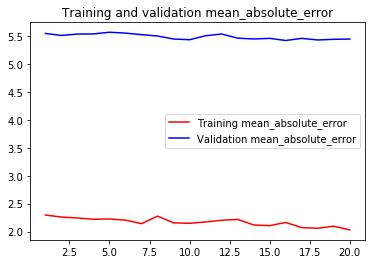

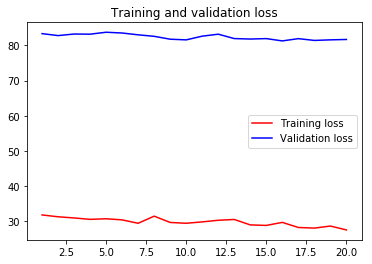

In [19]:
import matplotlib.pyplot as plt
def my_plot(h):  
    mae = h['mean_absolute_error']
    val_mae = h['val_mean_absolute_error']
    loss = h['loss']
    val_loss = h['val_loss']
    epochs = range(1,len(mae)+1)

    plt.plot(epochs,mae,'r',label='Training mean_absolute_error')
    plt.plot(epochs,val_mae,'b',label='Validation mean_absolute_error')
    plt.title('Training and validation mean_absolute_error')
    plt.legend()

    plt.figure()
    plt.plot(epochs,loss,'r',label='Training loss')
    plt.plot(epochs,val_loss,'b',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()
my_plot(history.history)

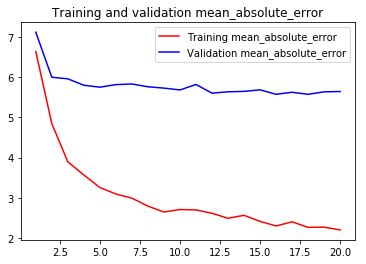

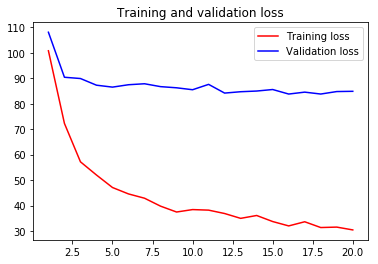

In [13]:
import matplotlib.pyplot as plt
def my_plot(h):  
    mae = h['mean_absolute_error']
    val_mae = h['val_mean_absolute_error']
    loss = h['loss']
    val_loss = h['val_loss']
    epochs = range(1,len(mae)+1)

    plt.plot(epochs,mae,'r',label='Training mean_absolute_error')
    plt.plot(epochs,val_mae,'b',label='Validation mean_absolute_error')
    plt.title('Training and validation mean_absolute_error')
    plt.legend()

    plt.figure()
    plt.plot(epochs,loss,'r',label='Training loss')
    plt.plot(epochs,val_loss,'b',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()
my_plot(history.history)

In [14]:
test_images=[]
for im in os.listdir(os.path.join(test_dir,'Test')):
    img=image.load_img(os.path.join(test_dir,'Test/'+im),target_size=(224,224))
    img=image.img_to_array(img)
    test_images.append(img)
test_images=np.array(test_images)
print(model.predict(test_images))

[[31.860611]]


In [16]:
from sklearn import svm
clf=svm.SVR(epsilon=10)
clf.fit(train_features,train_labels)
accuracy=clf.score(validation_features,validation_labels)
print(accuracy)
#SVRpredict=clf.predict(test_features)
#print(SVRpredict)

NameError: name 'train_features' is not defined

In [ ]:
#evaluate=model.evaluate(test_features,test_labels)
#print("Evaluate=")
#print(evaluate)